# 2025 ASAP CRN Colloborative Meeting - CRN Cloud Training Workshop Notebook #2

## Overview
This notebook is part 2: **Data Composition to create a smaller (more wieldy) _sub_- dataset**.   Some of the data aggregation steps with our relatively large `AnnData` objects can be slow, especially on the default JupyterApp VM.  Running this is _OPTIONAL_ and meant as demonstration.  We recommend scrolling through this notebook, and continuing onto Part 3 - Gene of interest analysis (__Workshop Activity__) [03_GOI_analysis.ipynb](./03_GOI_analysis.ipynb).


## Outline 

2. [`AnnData` Data Composition](#part-2-anndata-data-composition)
    * Load unfiltered dataset `AnnData` object
    * combine with _processed_ artifacts (`adata.obs`) 
    * Subset to a single brain region and Case-Contol group (from _dataset_ metadata)
        * annotate cell metadata with dataset metadata
        * save full gene expression `anndata` for subset with full metadata annotation (_dataset_ and _cell_-level)




## Notebooks
All of this content can be found in shorter more specific notebooks.  E.g. During the workshop you can follow along for Parts 1 & 2, but should start with Part 3 ([03_GOI_analysis.ipynb](./03_GOI_analysis.ipynb))

- This notebook [00_full_example_notebook.ipynb](./00_full_example_notebook.ipynb)
    - Part 1 - [01_basic_EDA.ipynb](./01_basic_EDA.ipynb)  
    - Part 2 - [02_dataset_composition.ipynb](./02_dataset_composition.ipynb)
    - Part 3 - [03_GOI_analysis.ipynb](./03_GOI_analysis.ipynb)
        - Part 3-R - [03-R_GOI_analysis.ipynb](./03-R_GOI_analysis.ipynb)
    - Part 4 - [04_DE_analysis.ipynb](./04_DE_analysis.ipynb)



------------------------------

## Imports

In [1]:
import numpy as np
import pandas as pd

# Use pathlib for file path manipulation
from pathlib import Path 


# matplotlib and seaborn a pythonic alternative to plotnine
try:
    import seaborn as sns
    import matplotlib.pyplot as plt
except ImportError as e:
    print("Error -> ", e)
    print("Installing seaborn or matplotlib")
    !pip install matplotlib seaborn
    import seaborn as sns
    import matplotlib.pyplot as plt


try:
    import scanpy as sc
except ImportError as e:
    print("Error -> ", e)
    print("Installing scanpy")
    !pip install scanpy
    import scanpy as sc

try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

# Always show all columns in a Pandas DataFrame
pd.set_option('display.max_columns', None)

time: 323 μs (started: 2025-03-06 19:54:14 +00:00)


###  ASAP CRN data paths
First, let's build the paths to our data. 

In [2]:
# Workspace Path
HOME_PATH = Path.home()
WS_PATH =  HOME_PATH / 'workspace'
if not WS_PATH.exists():
    print(f"{WS_PATH} doesn't exist. We need to remount our resources")
    !wb resource mount    

time: 749 μs (started: 2025-03-06 19:54:14 +00:00)


We'll focus in on the datasets processed with our *PMDBS scRNAseq* workflow.  Specifically the _cohort_ dataset: `asap-cohort-pmdbs-sc-rnaseq`.  This dataset includes samples from 5 Contributing datasets which have been processesed and integrated.  The paths include the following parts.

- `workflow` designates the workflow which performs the aggregation and integration.  In this case the [*PMDBS scRNAseq* workflow](https://github.com/ASAP-CRN/pmdbs-sc-rnaseq-wf)
- `dataset_team` designates the contributing team for the dataset.  In this case _cohort_ designates that it is made from multiple individual contributed datasets.
- `source` designates the _source_ of the samples.  In this case Post-mortem derived Brain samples
- `dataset_type` designates the 
- `bucket_name` designates the datasets gcp bucket
- `dataset_name` designates the unique designation for each dataset or collection

In [3]:
DATASETS_PATH = WS_PATH / "01_PMDBS_scRNAseq_Datasets"
workflow = "pmdbs_sc_rnaseq"
dataset_team = "cohort"
dataset_source = "pmdbs"
dataset_type = "sc-rnaseq"
bucket_name = f"asap-curated-{dataset_team}-{dataset_source}-{dataset_type}"
dataset_name = f"asap-{dataset_team}-{dataset_source}-{dataset_type}"
dataset_path = DATASETS_PATH / bucket_name / workflow

time: 1.55 ms (started: 2025-03-06 19:54:14 +00:00)


#### Cohort Analysis Path

Now that we've defined the path to our cohort dataset, lets list the curated files for the `cohort_analysis`.   

In [4]:
cohort_analysis_path = dataset_path / "cohort_analysis"

time: 387 μs (started: 2025-03-06 19:54:14 +00:00)


#### Dataset Metadata Path

The dataset metadata can be found in the `release_resources`.  Note that the metadata are organized by the _short_ `dataset_name` rather than `bucket_name`.  



In [5]:
ds_metadata_path = WS_PATH / 'release_resources/asap-crn-cloud-release-resources' / dataset_name / "metadata"

!ls {ds_metadata_path} 

ASSAY_RNAseq.csv  CONDITION.csv  PMDBS.csv     SAMPLE.csv  SUBJECT.csv
CLINPATH.csv	  DATA.csv	 PROTOCOL.csv  STUDY.csv
time: 868 ms (started: 2025-03-06 19:54:14 +00:00)


#### Workshop/Notebook Artifact Path

This is the path to where the artifacts we've created in these notebooks can be found in case you want to skip ahead.  Particularly for the workshop.  In which case you can replace the `local_data_path` with `WORKSHOP_PATH`.

In [6]:
WORKSHOP_PATH = WS_PATH / "release_resources/asap-crn-cloud-release-resources/release-artifacts/2025_CRN_CM_Workshop_Resources_03122025" 

!ls {WORKSHOP_PATH}

data  notebooks
time: 577 ms (started: 2025-03-06 19:54:15 +00:00)


#### Local Data Path
Lets also define a path for copying our data files and exporting intermediate analysis artifacts to your workspace.  In this example we'll make a "workshop_files" in the "ws_files" which are persistent in our Verily Workbench Workspace. 

In [7]:
local_data_path = WS_PATH / "workshop_files"

if not local_data_path.exists():
    local_data_path.mkdir(parents=True)

time: 858 μs (started: 2025-03-06 19:54:15 +00:00)


--------------

# Part 2: `AnnData` Data Composition 



The full `asap-cohort` PMDBS snRNAseq dataset contains gene expression (~36k genes) measurments of 2.7m cells.   We will subset to a smaller dataset of 290k prefrontal cortex cells.   

We will make this `AnnData` artifact available as the resources of loading the full dataset and subsetting can be.

An alternate strategy is to load each individual dataset individually, which is less resource intensive.  However, we would like to leverage the shared latent space for visualizations. 


Steps here.

* Load unfiltered dataset `AnnData` object
* combine with _processed_ artifacts (`adata.obs`) 
* Subset to a "frontal_ctx" brain region and Case-Contol group (from _dataset_ metadata)
    * save full gene expression `anndata` for subset with full metadata annotation (_dataset_ and _cell_-level)



### Subset by sample's brain region 

In the following we'll want to do a psuedo bulk differential expression analysis and also a simple meta-analysis over the individual contributions within the pan-ASAP CRN _cohort_ datasets.    Note that we are choosing to subset from the full asap-cohort so we can leverage the common UMAP.

First we need to load the _dataset_ metadata from Part 1.


In [8]:
dataset_metadata_filen = local_data_path / "asap-cohort-dataset-metadata.csv"

df = pd.read_csv(dataset_metadata_filen)

time: 18.6 ms (started: 2025-03-06 19:54:15 +00:00)


And then we can make the mapings from sample IDs to the metadata values.

In [9]:
# define sample to match
br_mapper_full = dict(zip(df["sample"], df["brain_region"]))
br_mapper_simple = dict(zip(df["sample"], df["brain_region_simple"]))

# Parkinsons and control samples
condition_id_mapper = dict(zip(df["sample"], df["condition_id"]))
case_id_mapper = dict(zip(df["sample"], df["intervention_id"]))

time: 2.64 ms (started: 2025-03-06 19:54:15 +00:00)


In [10]:
adata_filename = local_data_path / f"asap-{dataset_team}.final_adata.h5ad"
adata = sc.read_h5ad(adata_filename, backed="r")

# add brain region to adata.obs
obs = adata.obs.copy()

obs["brain_region"] = obs["sample"].map(br_mapper_full)
obs["brain_region_simple"] = obs["sample"].map(br_mapper_simple)
obs["case_id"] = obs["sample"].map(case_id_mapper)

frontal_cells = obs["brain_region_simple"] == "frontal_ctx"

time: 1min 38s (started: 2025-03-06 19:54:15 +00:00)


### Subset to "Case" or "Control" samples

Some of the contributed datasets include "Other" (e.g. 'prodromal PD') conditions besides "Ideopathic Parkinson's" and "Healthy Control".   We'll make a simplified dataset with just samples from Case (Parkinson's) and Control.  

In [11]:
case_control_cells = ~(obs["case_id"] == "Other")  # exclude "Other"

time: 202 ms (started: 2025-03-06 19:55:54 +00:00)


In [12]:
include = frontal_cells & case_control_cells

time: 15.8 ms (started: 2025-03-06 19:55:54 +00:00)



NOTE: We read the full 2.7m Cells X 36k genes from an h5ad file, NOT into memory.  Here we are copying the 291k cells into memory and closing the file.

In [13]:
frontal_ad = adata[include].to_memory()
adata.file.close()  # close the original adata file

time: 8.22 s (started: 2025-03-06 19:55:54 +00:00)


In [14]:
# add in any other metadata we'd like to use later?
frontal_ad.obs["case_control"] = frontal_ad.obs["sample"].map(case_id_mapper)
frontal_ad.obs["condition_id"] = frontal_ad.obs["sample"].map(condition_id_mapper)
frontal_ad.obs["case_id"] = frontal_ad.obs["sample"].map(case_id_mapper)
frontal_ad.obs["brain_region"] = frontal_ad.obs["sample"].map(br_mapper_simple)
frontal_ad

AnnData object with n_obs × n_vars = 291787 × 3000
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'total_counts', 'total_counts_rb', 'pct_counts_rb', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'sample', 'batch', 'team', 'dataset', 'batch_id', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.40', 'cell_type', 'case_control', 'condition_id', 'case_id', 'brain_region'
    var: 'feature_type', 'genome', 'gene_id', 'mt', 'rb'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'estimator', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_test_epoch', 'learning_curve_train_epoch', 'leiden', 'log1p', 'neighbors', 'pca', 'scrublet', 'target_false_positive_rate', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_scvi', 'X_umap', '_scvi_extra_continuous_covs', 'gene_expression_encoding'
    varm: 'PCs'
    layers:

time: 55.5 ms (started: 2025-03-06 19:56:02 +00:00)


Now we have a much smaller ~300k cells to work with, roughtly balanced btween Case and Control.

In [15]:
frontal_ad.obs["case_id"].value_counts()

case_id
Case       178065
Control    113722
Name: count, dtype: int64

time: 34.8 ms (started: 2025-03-06 19:56:02 +00:00)


Export subset for merging with full gene expression to our `local_data_path`.

In [16]:
frontal_samples_filename = (
    local_data_path / f"asap-{dataset_team}.frontal_ctx_case_control_samples.h5ad"
)
frontal_ad.write_h5ad(frontal_samples_filename)

time: 3.71 s (started: 2025-03-06 19:56:02 +00:00)


Although we've subset to a much smaller dataset, we can see in our UMAP visualization that we have a wide ssampling of the overall gene expression latent space. 

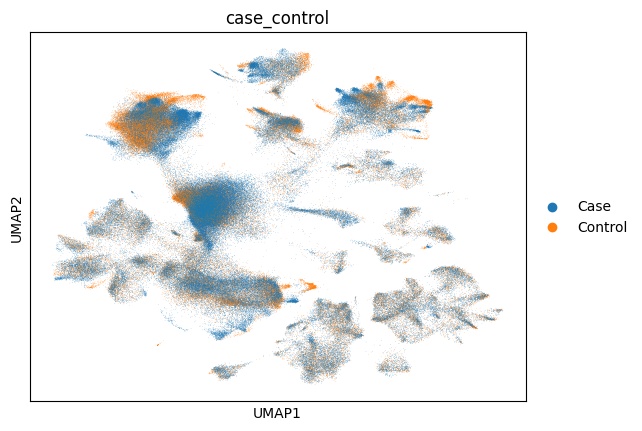

time: 2.06 s (started: 2025-03-06 19:56:06 +00:00)


In [17]:
sc.pl.embedding(frontal_ad, basis="umap", color=["case_control"])

In [18]:
del adata, frontal_ad

time: 430 μs (started: 2025-03-06 19:56:08 +00:00)


## Compose subset `AnnData` summary object 

### Copy dataset `anndata` to workspace 

Loading the dataset directly from the gcp bucket is inefficient.  Lets first copy it to our workspace files.

In [19]:
full_adata_filename = (
    cohort_analysis_path / f"asap-{dataset_team}.merged_adata_object.h5ad"
)
l_full_adata_filename = (
    local_data_path / f"asap-{dataset_team}.merged_adata_object.h5ad"
)

time: 1.61 ms (started: 2025-03-06 19:56:08 +00:00)


In [20]:
if not l_full_adata_filename.exists():
    !cp {full_adata_filename} {l_full_adata_filename}

time: 6min 27s (started: 2025-03-06 19:56:08 +00:00)


### Load _full_ gene expression 
 
We'll construct an adata having the full (not limited to highly variable genes) gene expression, by combining the the subset adata (with all the embeddings and analyses) with the `asap-cohort.merged_adata_object.h5ad`.

In [21]:
full_adata = sc.read_h5ad(l_full_adata_filename, backed="r")

frontal_samples_filename = (
    local_data_path / f"asap-{dataset_team}.frontal_ctx_case_control_samples.h5ad"
)
frontal_ad = sc.read_h5ad(frontal_samples_filename, backed="r")

var_ = full_adata.var.copy()
X = full_adata[frontal_ad.obs_names].X.copy()

full_adata.file.close()

time: 1min 48s (started: 2025-03-06 20:02:35 +00:00)


Now we can combine the _full_ gene expression matrix wit ouyr frontal cortex subset, and save the resulting `AnnData`object.

In [22]:
frontal_full_ad = sc.AnnData(
    X=X,
    obs=frontal_ad.obs,
    var=var_,
    uns=frontal_ad.uns,
    obsm=frontal_ad.obsm,
)

time: 59.3 ms (started: 2025-03-06 20:04:24 +00:00)


### Export full frontal cortex `AnnData` object for further analysis


In [ ]:
frontal_full_samples_filename = (
    local_data_path / f"asap-{dataset_team}.full_frontal_ctx_case_control_samples.h5ad"
)
frontal_full_ad.write_h5ad(frontal_full_samples_filename)

-----------------
# Next:   
Continue with:
- Part 3 - Gene of interest analysis (__Workshop Activity__) [03_GOI_analysis.ipynb](./03_GOI_analysis.ipynb)


--------------------
# Provenance
Generate information about this notebook environment and the packages installed.

In [ ]:
!date

pip installed packages:

In [ ]:
!pip freeze

JupyterLab extensions:

In [ ]:
!jupyter labextension list

Number of cores:

In [27]:
!grep ^processor /proc/cpuinfo | wc -l

time: 366 ms (started: 2025-03-06 20:06:30 +00:00)


Memory:

In [28]:
!grep "^MemTotal:" /proc/meminfo

MemTotal:       107131888 kB
time: 338 ms (started: 2025-03-06 20:06:30 +00:00)
